# We analyze the IAAF 100m and 200m all-time men and women lists # 

In [217]:
import sys
import requests
import lxml.html as lh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Scraping the data from the IAAF website to build pandas DataFrames ##


In [2]:
# user controls these three variables

# choose gender: men or women
igender1 = 'men'

# choose whether to include both genders (True) or not (False)
inclboth = True

# choose number of pages of results we want to include from the IAAF lists (for both genders)
# 0<npage<=17
npage=15

In [3]:
# determine other gender
if igender1=='women':
    igender2 = 'men'
elif igender1=='men':
    igender2 = 'women'
else:
    sys.exit("I know that gender is non-binary but not for the IAAF. Stop.")

In [4]:
# need this header to open the page from my laptop
headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:64.0) Gecko/20100101 Firefox/64.0'}

# create empty final lists
tr1_elements_final = []
tr2_elements_final = []

ip=1
while ip<=npage:
    
    # get url and create a page
    url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/' + igender1 + '/senior?page=' + str(ip)
    url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/' + igender1 + '/senior?page=' + str(ip)
    page1 = requests.get(url1, headers=headers)
    page2 = requests.get(url2, headers=headers)
    
    # store the contents of the website
    doc1 = lh.fromstring(page1.content)
    doc2 = lh.fromstring(page2.content)
    
    # parse data that are stored between <tr>..</tr> of HTML
    tr1_elements = doc1.xpath('//tr')
    tr2_elements = doc2.xpath('//tr')
    
    if ip==1:
        # in our case the table starts at position 18 (with the header)
        tr1_elements_final += tr1_elements[18:]
        tr2_elements_final += tr2_elements[18:]
    else:
        # without including the header again
        tr1_elements_final += tr1_elements[19:]
        tr2_elements_final += tr2_elements[19:]
        
    ip+=1
    
# include other gender's results if required
if inclboth:
    ip=1
    while ip<=npage:
        url1='http://www.iaaf.org/records/all-time-toplists/sprints/100-metres/outdoor/' + igender2 + '/senior?page=' + str(ip)
        url2='http://www.iaaf.org/records/all-time-toplists/sprints/200-metres/outdoor/' + igender2 + '/senior?page=' + str(ip)
        page1 = requests.get(url1, headers=headers)
        page2 = requests.get(url2, headers=headers)
        doc1 = lh.fromstring(page1.content)
        doc2 = lh.fromstring(page2.content)
        tr1_elements = doc1.xpath('//tr')
        tr2_elements = doc2.xpath('//tr')
    
        # without including the header again
        tr1_elements_final += tr1_elements[19:]
        tr2_elements_final += tr2_elements[19:]
        ip+=1

In [5]:
# create empty list
col1=[]
col2=[]

#For each row, store each first element (header) and an empty list
i=0
for t in tr1_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col1.append((name,[]))

i=0
for t in tr2_elements_final[0]:
    i+=1
    name=t.text_content()
    name=name.strip()
    #print '%d:"%s"'%(i,name)
    col2.append((name,[]))

In [6]:
#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr1_elements_final)):
    #T is our j'th row
    T=tr1_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col1[i][1].append(data)
        #Increment i for the next column
        i+=1
        
for j in range(1,len(tr2_elements_final)):
    #T is our j'th row
    T=tr2_elements_final[j]
    
    #If row is not of size 11, the //tr data is not from our table 
    if len(T)!=11:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data=data.strip()
        #Append the data to the empty list of the i'th column
        col2[i][1].append(data)
        #Increment i for the next column
        i+=1

In [7]:
Dict1={title:column for (title,column) in col1}
Dict2={title:column for (title,column) in col2}

# there's a key with all blank entries so we get rid of it
del Dict1['']
del Dict2['']

# create DataFrames
df1=pd.DataFrame(Dict1)
df2=pd.DataFrame(Dict2)

# changing header name
df1.rename(columns={'Mark':'100m'}, inplace=True)
df2.rename(columns={'Mark':'200m'}, inplace=True)

## We analyze the 100m lists and visualize our findings ##

### I. Nationalities with most all-timers ####

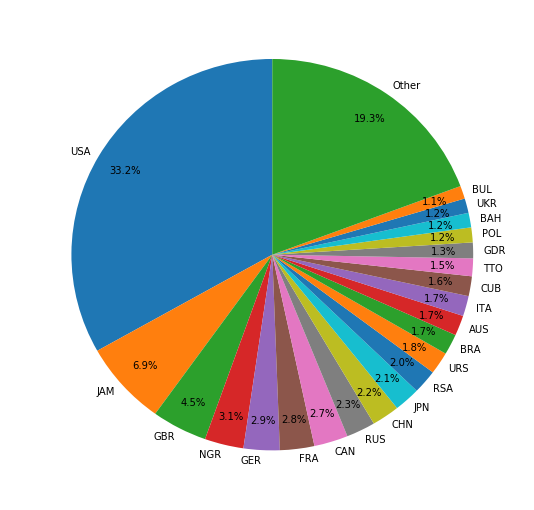

In [8]:
# create ranking
df1natcount=df1['Nat'].value_counts()
df1natcount_above=df1natcount[df1natcount>=30]
df1natcount_below=pd.Series([len(df1.index)-df1natcount_above.sum()],index=['Other'])
df1natcount_final=df1natcount_above.append(df1natcount_below)

# plot
plt.figure(figsize=(9,9))
df1natcount_final.plot(kind='pie', autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.05, startangle=90, shadow=False, legend = False, fontsize=10)

plt.axis('off')
plt.show()

### II. Age at PB ###

In [9]:
# function to convert age in days to age in years
def get_age(ndays):
    # handle NaNs: assign negative age
    if ndays!=ndays:
        age=-1.0
    # account for leap years    
    else:
        age=float(ndays/365.25)
    return age

# get DOBs and Dates
df1_dobs=pd.to_datetime(df1['DOB'])
df1_dates=pd.to_datetime(df1['Date'])

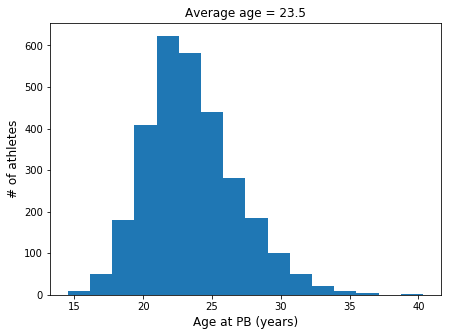

In [10]:
# get ages at PBs
df1_timediff=df1_dates-df1_dobs
df1_timediff=df1_timediff.dt.days
df1_ages=pd.Series([get_age(item) for item in df1_timediff])
df1_ages_final=df1_ages[df1_ages>0]

# plot
plt.figure(figsize=(7,5))
plt.hist(df1_ages_final, bins=16)
plt.title('Average age = %.1f' % df1_ages_final.mean(), size=12)
plt.xlabel('Age at PB (years)', size=12)
plt.ylabel('# of athletes', size=12)
plt.show()

### III. Youngest and oldest in the all-time lists ###

In [11]:
# determine mininum age
df1_minage=df1_ages_final.min()

# determine location and print out info
df1_minageloc=df1_ages[df1_ages==df1_minage].index[0]

print df1.iloc[df1_minageloc]
print
print 'Age (years): %.1f' % df1_minage

Competitor              Tia CLAYTON
DOB                     17 AUG 2004
Date                    26 FEB 2019
100m                          11.37
Nat                             JAM
Pos                               1
Rank                           1025
Results Score                  1120
Venue            Spanish Town (JAM)
WIND                           +1.7
Name: 2560, dtype: object

Age (years): 14.5


In [12]:
# determine maximum age
df1_maxage=df1_ages_final.max()

# determine location and print out info
df1_maxageloc=df1_ages[df1_ages==df1_maxage].index[0]

print df1.iloc[df1_maxageloc]
print
print 'Age (years): %.1f' % df1_maxage

Competitor       Irina KHABAROVA
DOB                  18 MAR 1966
Date                 15 JUL 2006
100m                       11.18
Nat                          RUS
Pos                            1
Rank                         365
Results Score               1161
Venue                 Tula (RUS)
WIND                        +1.0
Name: 1872, dtype: object

Age (years): 40.3


### IV. Years with most PBs ###

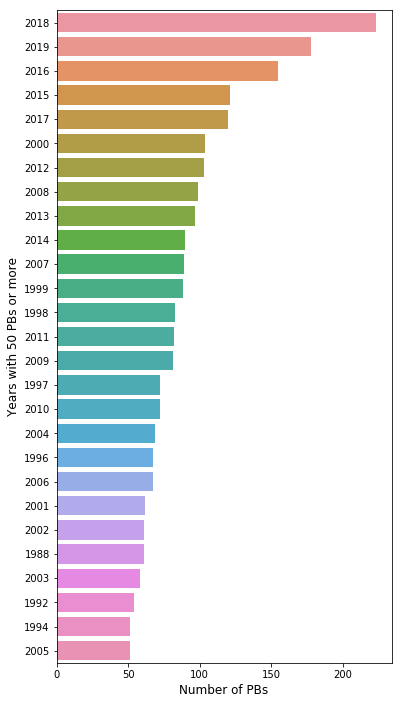

In [13]:
# create dataframe with only year in 'Date' field and keep only years with most PBs
df1_copy=df1.copy()
df1_copy['Date']=pd.to_datetime(df1['Date']).dt.year
df1_yearcount = df1_copy['Date'].value_counts()
df1_yearcountfinal_index = df1_yearcount[df1_yearcount>=50].index
df1_yearplt = df1_copy[df1_copy['Date'].isin(df1_yearcountfinal_index)].copy()

# plot
plt.figure(figsize=(6,12))
sns.countplot(y='Date', data=df1_yearplt, order=df1_yearcountfinal_index)
plt.xlabel('Number of PBs', size=12)
plt.ylabel('Years with 50 PBs or more', size=12)
plt.show()

## We create a combined 100m-200m list and we study whether a regression model can be built between 100m and 200m PBs of all-time athletes ##

In [14]:
df3=pd.merge(df1[['Competitor','100m']], df2[['Competitor','200m']], on='Competitor')

Text(0,0.5,u'200m (s)')

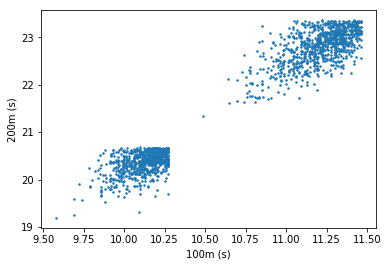

In [234]:
# convert to float
df3 = df3.astype({'100m': float, '200m': float})

# create X and Y arrays for regression
Xval = df3['100m']
Yval = df3['200m']

# split X into random train and test sets
X_train, X_test, y_train, y_test = train_test_split(Xval,Yval,test_size=0.3)

# scatter plot
ax = df3.plot(x='100m', y='200m', style='.', ms=3, legend=False)
ax.set_xlabel("100m (s)")
ax.set_ylabel("200m (s)")

### I. Performing linear regression using scikit-learn LinearRegression ###

In [235]:
# LinearRegression
lm = linear_model.LinearRegression()
lm.fit(X_train.values.reshape(-1,1),y_train)

# model predictions of test set
Ypredictionslm = lm.predict(X_test.values.reshape(-1,1))

In [236]:
# get R-squared
R2lm=lm.score(X_test.values.reshape(-1,1),y_test)
print 'R2_lm = ',R2lm

# get slope
coeflm=lm.coef_
print 'coeff_lm = ',coeflm

# get intercept
constlm=lm.intercept_
print 'intercept_lm = ',constlm

# test model for a random input
lm.predict([[9.99]])

R2_lm =  0.95316692255369
coeff_lm =  [2.18350198]
intercept_lm =  -1.7021357092482354


array([20.1110491])

### II. Performing linear regression using scikit-learn SGDRegressor (Stochastic Gradient Descent) ### 

In [237]:
# SGDRegressor
clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3, loss='huber')
clf.fit(X_train.values.reshape(-1,1),y_train)

# model predictions of test set
Ypredictionsclf = clf.predict(X_test.values.reshape(-1,1))

In [338]:
# get R-squared
R2clf=clf.score(X_test.values.reshape(-1,1),y_test)
print 'R2_clf = ',R2clf

# get slope
coefclf=clf.coef_
print 'coeff_clf = ',coefclf

# get intercept
constclf=clf.intercept_
print 'intercept_clf = ',constclf

# test model for a random input
clf.predict([[9.99]])

R2_clf =  0.9424717861110573
coeff_clf =  [2.00263886]
intercept_clf =  [0.18028285]


array([20.18664509])

### III. Performing regression using a neural network (MLPRegressor) ###

In [331]:
# MLPRegressor with:
# one hidden layer with 100 neurons
# logistic sigmoid activation function
# lbfgs solver for weight optimization
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', solver='lbfgs')
mlp.fit(X_train.values.reshape(-1,1),y_train)

# model predictions of test set
Ypredictionsmlp = mlp.predict(X_test.values.reshape(-1,1))

In [332]:
# get R-squared
R2mlp=mlp.score(X_test.values.reshape(-1,1),y_test)
print 'R2_mlp = ',R2mlp

# test model for a random input
mlp.predict([[9.99]])

R2_mlp =  0.9533665938545757


array([20.09416653])

### IV. Comparison between models ###

In [333]:
# % difference between truth and predictions for test set for LinearRegressions
lmdiff=100*(y_test-Ypredictionslm)/y_test

# % difference between truth and predictions for test set for SGDRegressor
clfdiff=100*(y_test-Ypredictionsclf)/y_test

# % difference between truth and predictions for test set for MLPRegressor
mlpdiff=100*(y_test-Ypredictionsmlp)/y_test

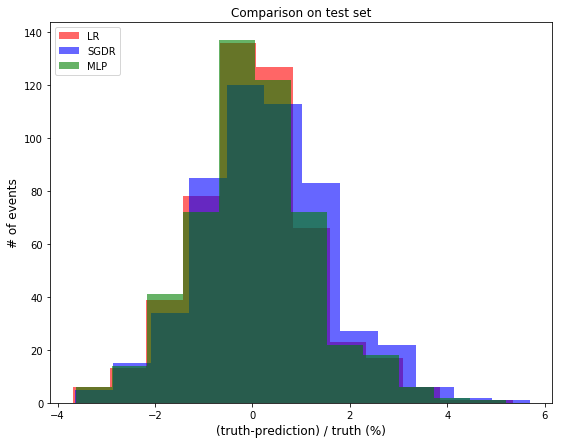

In [334]:
# plot histograms
plt.figure(figsize=(9,7))
plt.hist(lmdiff, bins=12, alpha=0.6, label='LR', color='red')
plt.hist(clfdiff, bins=12, alpha=0.6, label='SGDR', color='blue')
plt.hist(mlpdiff, bins=12, alpha=0.6, label='MLP', color='green')
plt.legend(loc='upper left')
plt.title('Comparison on test set', size=12)
plt.xlabel('(truth-prediction) / truth (%)', size=12)
plt.ylabel('# of events', size=12)
plt.show()

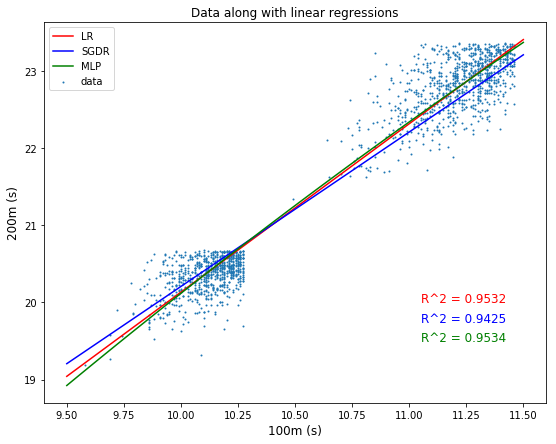

In [337]:
# plot data
plt.figure(figsize=(9,7))
plt.scatter(Xval, Yval, s=4, marker='.', label='data')

# plot linear regressions
Xplt = np.linspace(9.50,11.50,100)
Yplt_lm = coeflm[0]*Xplt+constlm
Yplt_clf = coefclf[0]*Xplt+constclf[0]
Yplt_mlp = mlp.predict(Xplt.reshape(-1,1))

plt.plot(Xplt,Yplt_lm,'r',label='LR')
plt.plot(Xplt,Yplt_clf,'b',label='SGDR')
plt.plot(Xplt,Yplt_mlp,'g',label='MLP')
plt.legend(loc='upper left')
plt.title('Data along with linear regressions', size=12)
plt.xlabel('100m (s)', size=12)
plt.ylabel('200m (s)', size=12)

# compare R2 scores
plt.text(11.05,20.00,'R^2 = %.4f' % R2lm, size=12, color='red')
plt.text(11.05,19.75,'R^2 = %.4f' % R2clf, size=12, color='blue')
plt.text(11.05,19.50,'R^2 = %.4f' % R2mlp, size=12, color='green')

plt.show()

To do list:  
- Filter data (PBs years apart probably not very reliable etc)

## References ###
[1] https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059  
[2] https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9  
[3] https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9    
[4] https://github.com/srcole/insightfellows  
[5] https://scikit-learn.org/stable/  
[6] https://stackoverflow.com/